# Data Science Challenge

Problema a resolver:

> Dentro del marketplace existen productos similares o idénticos entre sí (son productos vendidos por distintos sellers, en la api puedes obtener y descargar los títulos e incluso las imágenes!). ¿Cómo buscar dichos ítems para agruparlos y volverlos comparables entre sí? Esto permitiría mejorar la experiencia ante muchas opciones similares.

Este es un problema clásico de agrupamiento. La solución propuesta compara la información en los títulos o en los atributos de cada producto para encontrar otros productos dentro de la misma subcategoría que se le asemejen. La información contenida en las imágenes de los productos también podría ser útil en este tarea, pero no fue necesaria para obtener este primer prototipo. Además, comparar imágenes incurre en mayores costos de implementación y de computación posteriores. Otro tipo de información que hubiese resultado útil es la de visitas, pero esta no se encuentra disponible en la API pública por lo que pude ver (sí se puede ver cuantas visitas recibió un seller o item, pero no se pueden ver las visitas de cada comprador).

In [1]:
import requests

import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

import sklearn.feature_extraction.text as sktext
import sklearn.neighbors as skneigh
import sklearn.manifold as skmani

%matplotlib inline

In [2]:
def attr_parser(item_attrs, cat_attrs):
    """
    Función para parsear y ordenar los atributos de cada item
    de acuerdo a los atributos de su categoría.
    
    Parameters
    ----------
    
    items_attrs : list
        Lista con los atributos de cada item.
        Obtenida de f'https://api.mercadolibre.com/items/{item_id}'.
        
    cat_attrs : list
        Lista con los atributos de la categoría.
        Obtenida de f'https://api.mercadolibre.com/categories/{cat_id}/attributes'.
        
    Returns
    -------
    
    parsed : list
        Lista con los atributos del item ordenados según cat_attrs
        y transformado a valores numéricos (floats).
    """
    
    parsed = []
    for base_attr in cat_attrs:
        attr_id = base_attr['id'] 

        # Look for attribute
        attribute_found = False
        for attr in item_attrs:
            if attr['id'] == attr_id:
                value_type = base_attr['value_type']
                try:
                    if   value_type == 'number':
                        parsed.append(float(attr['value_name']))
                    elif value_type == 'number_unit':
                        # TODO: conversor de unidades
                        parsed.append(attr['value_struct']['number']) 
                    elif value_type == 'string':
                        # TODO: apply tokenizer to attribute
                        parsed.append(float(attr['value_id']))
                    elif value_type == 'boolean':
                        parsed.append(1.0 if attr['value_id']=='242085' else 0.0)
                    elif value_type == 'list':
                        # TODO: implement list parsing
                        parsed.append(0.0)
                except:
                    parsed.append(0.0)
                
                attribute_found = True
                break

        # Attribute not found
        if not attribute_found:
            parsed.append(0.0)
    
    return parsed

In [3]:
# Target
site_id = 'MLA' # Argentina

# target_id = f'{site_id}1100783124' # Pila AAA
target_id = f'{site_id}1101556021' # Multiprocesadora

In [4]:
# Get item
# Extract info from target item
url  = f'https://api.mercadolibre.com/items/{target_id}'
req  = requests.get(url)
info = req.json()
target = info['title']

print('Item a buscar:', target)

Item a buscar: Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v


Obtengo la categoría y busco sus atributos. Gracias al esfuerzo puestos en generar y mantener un buen árbol de categorías es fácil restringir el universo de búsquedas.

Cabe destacar que funciones de la API tales como _domain discovery_ realizan una tarea similar a la aquí propuesta y sería interesante comparar approaches.

In [5]:
# Get categoy and attributes
cat_id = info['category_id']
url = f'https://api.mercadolibre.com/categories/{cat_id}/attributes'
req = requests.get(url)
cat_attrs = req.json()
target_attr = attr_parser(info['attributes'], cat_attrs)
target_attr = np.array(target_attr).reshape(1,-1)
target_loc  = info['seller_address']['search_location']['state']['id']

In [6]:
# Get items in categories
limit = 50
items = []

url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}'
req = requests.get(url)
total = req.json()['paging']['total']

if total>1000: total = 1000 # Sin AUTHTOKEN no deja ver más de 1000 registros
total = 200 ##### ACTUALIZAR ESTO DESPUES

items = items + req.json()['results']
for offset in range(limit, total, limit):
    url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}&offset={offset}'
    req = requests.get(url)
    info  = req.json()
    
    items = items + info['results']

Se podría crear un diccionario más grande viendo las descripciones en /items/{item_id}/description

In [36]:
# Extract features from items
titles      = []
item_ids    = []
attributes  = []
for unit in items:
    url  = f'https://api.mercadolibre.com/items/{unit["id"]}'
    req  = requests.get(url)
    info = req.json()
    try:
        # Restricción geográfica
        if info['seller_address']['search_location']['state']['id'] == target_loc:
            item_ids.append(info['id'])
            titles.append(info['title'])
            attributes.append(attr_parser(info['attributes'], cat_attrs))
    except KeyError:
        pass
    
titles     = np.array(titles)
item_ids   = np.array(item_ids)
attributes = np.array(attributes)

Algunos atributos están ordenados y hasta pueden ser contínuos, como el precio, pero otros, como la marca, no. Esto puede tener consecuencias interesantes a la hora de comparar atributos.

In [40]:
# Normalizo atributos
print(np.shape(attributes))
attrs_max = attributes.max(axis=0)
attrs_max[attrs_max==0.0] = 1

(141, 51)


In [45]:
target_attr = target_attr/attrs_max
attributes  = attributes/attrs_max

# Arranco con ML

## Agrupación por texto

In [46]:
# Tokenizo y normalizo los títulos
count_vect = sktext.CountVectorizer()
tfidf_tran = sktext.TfidfTransformer()

X = count_vect.fit_transform(titles)
X = tfidf_tran.fit_transform(X)

In [47]:
# Armo el mapa
nnalg_text = skneigh.NearestNeighbors()
nnalg_text.fit(X)

NearestNeighbors()

In [68]:
# Realizo la predicción
predict = count_vect.transform([target])
predict = tfidf_tran.transform(predict)
res_text = nnalg_text.kneighbors(predict, return_distance=False)

print(np.array(titles)[res_text[0]])

['Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v'
 'Multiprocesadora Smartlife Con Licuadora 1000w Fp509 Acero'
 'Multiprocesadora Liliana Fullpros Am790 1000w Negra 220v - 240v'
 'Multiprocesadora Liliana Fullprocessor Am780 750w Negra 220v - 240v'
 'Multiprocesadora Liliana Simply Am600 650w Negra 220v - 240v']


In [49]:
total_text_dist, total_text_idxs = nnalg_text.kneighbors(X)

## Agrupación por atributos

In [50]:
# Armo el mapa
#attributes = attributes/attributes.max()
nnalg_attr = skneigh.NearestNeighbors()
nnalg_attr.fit(attributes)

NearestNeighbors()

In [61]:
# Realizo la predicción
res_attr = nnalg_attr.kneighbors(target_attr, return_distance=False)

print(np.array(titles)[res_attr[0]])

['Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v'
 'Multiprocesadora Smartlife Con Licuadora 1000w Fp509 Acero'
 'Multiprocesadora Electrolux Fpl21 600w Negra 220v'
 'Multiprocesadora Electrolux 600w 1,2lt 3 Vel Fpl21 Licuadora'
 'Multiprocesadora Electrolux 600w 1,2 Lts 3 Velocidades Fpl20']


In [52]:
total_attr_dist, total_attr_idxs = nnalg_attr.kneighbors(attributes)

## Comparación

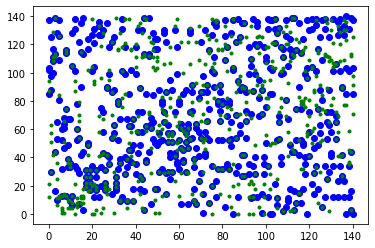

In [53]:
plt.plot(total_attr_idxs[:,1:], 'bo')
plt.plot(total_text_idxs[:,1:], 'g.')

In [54]:
np.sum(np.sort(total_attr_idxs[:,1:])==np.sort(total_text_idxs[:,1:]))/(4*len(titles))

0.17553191489361702

In [55]:
ii = 43
print(np.array(titles)[total_attr_idxs[ii]],'\n',np.array(titles)[total_text_idxs[ii]])

[' Multiprocesadora Liliana Procelic Licuadora Picador Rallado'
 'Multi Procesadora + Licuadora Experty Liliana 6 En 1 Am730'
 'Procesadora Multiprocesadora Industrial Moretti Vc-65 Cuotas'
 'Multiprocesadora Liliana Procelic 650w Am640 + Licuadora '
 'Mini Procesadora Moulinex La Moulinette Picadora Outlet'] 
 [' Multiprocesadora Liliana Procelic Licuadora Picador Rallado'
 'Multiprocesadora Liliana Procelic 650w Am640 + Licuadora '
 'Multiprocesadora Liliana Procelic Am640 650w Blanca 220v - 240v'
 'Picador De Alimentos Ultracomb 600w Pc-6800'
 'Multiprocesadora Licuadora Liliana 650w Picadora 3 Vel + Pul']


In [56]:
ii = 37
print(np.array(titles)[total_attr_idxs[ii]],'\n',np.array(titles)[total_text_idxs[ii]])

['Smart-tek Sm2026 Easy Chop Rebanador Cortador Rallador Acero'
 'Rallador Rebanador Electrico Smart-tek Easychop Sm3026 150w '
 'Rallador Eléctrico Smart-tek Easy Chop Verduras Queso Rebanador'
 'Mini Procesadora 900 Ml Chopper Manual 2 En 1 + Batidora '
 'Rallador Electrico Fruta Verdura'] 
 ['Smart-tek Sm2026 Easy Chop Rebanador Cortador Rallador Acero'
 'Rallador Eléctrico Smart-tek Easy Chop Verduras Queso Rebanador'
 ' Rebanador Electrico Easy Chop Verduras Queso Rallador'
 'Rallador Rebanador Electrico Smart-tek Easychop Sm3026 150w '
 'Rallador Cortador De Alimentos Ultracomb 150w Gr-2600']


Consideraciones posibles: separar por seller, marca, precio, etc. Esto depende un poco de la estrategia de venta y que se le quiere mostrar al usuario. Se puede implementar desde el mismo algoritmo de Nearest Neighbors pasandole una métrica que pese más o menos a las distintas variables, o post-procesando los resultados también.

# Visulizaciones

In [57]:
tsne = skmani.TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

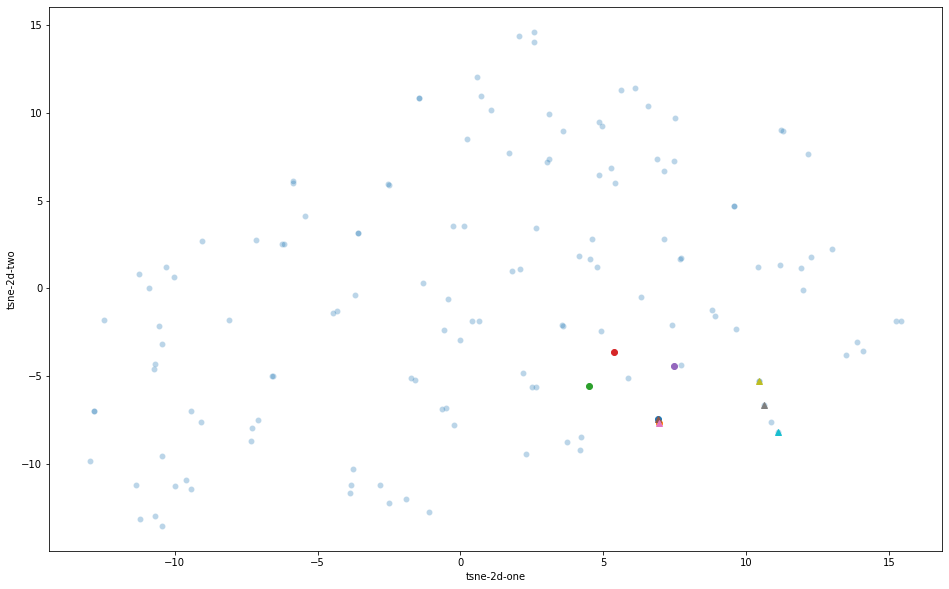

In [63]:
data = {}
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.3
)

for ii in res_text[0]:
    plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'o')
    
for ii in res_attr[0]:
    plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], '^')
